In [2]:
# imports

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# read in all the words

words = open('names.txt', 'r').read().splitlines()
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [4]:
# build the vocabulary of characters and the mappings

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [5]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.': 
            X.append(context)
            idx = stoi[ch]
            Y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

X, Y = build_dataset(words[:1])

import random 
random.seed(0)
random.shuffle(words)
idx1 = int(0.8 * len(words))
idx2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:idx1])
Xval, Yval = build_dataset(words[idx1:idx2])
Xtest, Ytest = build_dataset(words[idx2:])

In [17]:
# MLP

# we can ease the optimization by fixing our weight initialization
# we expect a relatively even distribution of next character expectation to start,
# so we want our first iteration of logits to be close to 0

n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(0)
C = torch.randn((27, n_emb), generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g) 
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01 
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]
total_parameters = 0
for p in parameters:
    p.requires_grad = True
    total_parameters += p.nelement()
total_parameters

11897

In [18]:
# optimization 

max_steps = 200000
batch_size = 32
lossi = []

In [ ]:
# training loop 

for k in range(max_steps):
    # minibatch
    idxs = torch.randint(0, idx1, (batch_size,))

    # forward pass
    xemb = C[Xtr[idxs]]
    hpreact = xemb.view(-1, block_size * n_emb) @ W1 + b1 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[idxs])

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if k < max_steps // 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if k % 10000 == 0:
        print(f'{k}/{max_steps}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

0/200000: 3.3051
10000/200000: 2.3384
20000/200000: 1.7958
30000/200000: 2.0619
40000/200000: 2.3093
50000/200000: 1.8834
60000/200000: 2.1387
70000/200000: 2.3201
80000/200000: 2.0852
90000/200000: 1.8192
100000/200000: 2.2072
110000/200000: 1.6587
120000/200000: 1.7450
130000/200000: 1.6647
140000/200000: 1.5953
150000/200000: 1.6957
160000/200000: 1.6871
170000/200000: 2.1283
180000/200000: 2.0630


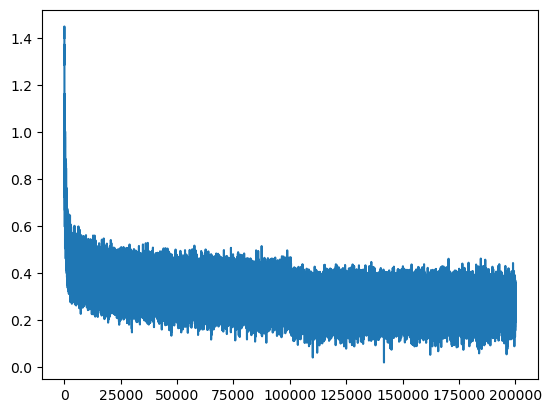

In [15]:
plt.plot(lossi)

In [14]:
# get loss for each split
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval), 
        'test': (Xtest, Ytest)
    }[split]
    emb = C[x]
    h = torch.tanh(emb.view(-1, n_emb * block_size) @ W1 + b1)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, y)
    return loss

print(f'train loss: {split_loss('train')}')
print(f'val loss: {split_loss('val')}')
print(f'test loss: {split_loss('test')}')

train loss: 2.3622829914093018
val loss: 2.435384511947632
test loss: 2.3980650901794434


*No Changes*

train loss: 2.3622829914093018

val loss: 2.435384511947632

test loss: 2.3980650901794434

In [44]:
# sampling from the model

def sample(num):
    for _ in range(num):
        context = [0] * block_size
        word = ''
        while True:
            emb = C[torch.tensor(context)]
            h = torch.tanh(emb.view(-1, n_emb * block_size) @ W1 + b1)
            logits = h @ W2 + b2 
            probs = torch.softmax(logits, dim=1)
            idx = torch.multinomial(probs, 1, replacement=True).item()
            if idx == 0:
                break
            word += itos[idx]
            context = context[1:] + [idx]
        print(word)
    
sample(10)

samarian
hun
ombsren
qmormadelynsly
kolon
liegon
kangrin
tlandaritsa
hel
trachamerrier
